# IRRADIANCIA RESUELTA ESPECTRALMENTE

In [22]:
from pvlib import spectrum, solarposition, irradiance, atmosphere
import pandas as pd
import matplotlib.pyplot as plt
import module_AoiGrids as gr
import module_Cell as cell
from scipy.interpolate import InterpolatedUnivariateSpline as interp

Se presentan todas las caracteristicas necesarias para concoer la irradiancia espectral

In [74]:
caracteristics={
    'lat':40.544,
    'lon':-3.613,
    'tz':'Europe/Madrid',
    'date':'2021-06-21 8:00',
    'pressure':92350,
    'water_vapor_content':0.6,
    'tau500':0.1,
    'ozone':0.308,
    'albedo':0.2,
    }
caracteristics_module={    
    'tilt':30,
    'surface_azimuth':180,
    'radius':0.6,
    'area':179*10**-6
    }


In [61]:
times = pd.date_range(caracteristics['date'], freq='60min', periods=14,tz=caracteristics['tz'])
solpos = solarposition.get_solarposition(times, caracteristics['lat'], caracteristics['lon'])
aoi = irradiance.aoi(caracteristics_module['tilt'], caracteristics_module['surface_azimuth'], solpos.apparent_zenith, solpos.azimuth)
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith,model='kasten1966')

In [62]:
spectra = spectrum.spectrl2(
    apparent_zenith=solpos.apparent_zenith,
    aoi=aoi,
    surface_tilt=caracteristics_module['tilt'],
    ground_albedo=caracteristics['albedo'],
    surface_pressure=caracteristics['pressure'],
    relative_airmass=relative_airmass,
    precipitable_water=caracteristics['water_vapor_content'],
    ozone=caracteristics['ozone'],
    aerosol_turbidity_500nm=caracteristics['tau500'],
)

Podemos obtener así la distirbución espectral a lo largo de un día para distintas horas

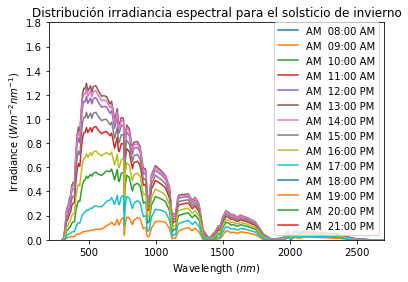

In [63]:
plt.figure()
plt.plot(spectra['wavelength'], spectra['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")
plt.title("Distribución irradiancia espectral para el solsticio de invierno")
time_labels = times.strftime("%H:%M %p")
labels = [
    "AM  {}".format(*vals)
    for vals in zip(time_labels)
]
plt.legend(labels)
plt.show()

# CURVA FOTOPICA VALORES

Se extraen los valores normalizados de la curva fotópica en tanto por uno

In [64]:

effic=[0.000039,0.000120,0.000396,0.001210,0.004000,0.011600,0.023000,0.038000,0.060000,0.090980,0.139020,0.208020,0.32300,0.444310, 0.503000,0.710000,0.862000,0.954000,0.994950,1.000000,0.995000,0.952000,0.870000,0.757000,0.631000,0.503000,0.381000,0.265000,0.175000, 0.107000,0.061000,0.032000,0.017000,0.008210,0.004102,0.002091,0.001047,0.000520,0.000249,0.000120,0.000060,0.000030]
wave_len=[380,390,400,410,420,430,440,450,460,470,480,490,500,507,510, 520, 530, 540, 550,555,560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770]

effic_=pd.Series(effic)
effic_.index=wave_len


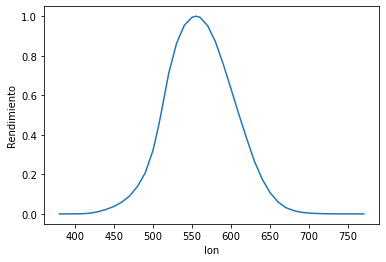

In [65]:
effic_.plot()
plt.xlabel('lon')
plt.ylabel('Rendimiento')
plt.show()

In [66]:
photopic_curve=interp(wave_len,effic,k=3)

# USO CURVA FOTOPICA CON LA IRRADIANCIA ESPECTRAL

Aplicamos a la irradiancia espectral la integral de la fotópica, para así obtener la irradiancia real que se va a utilizar para iluminacion

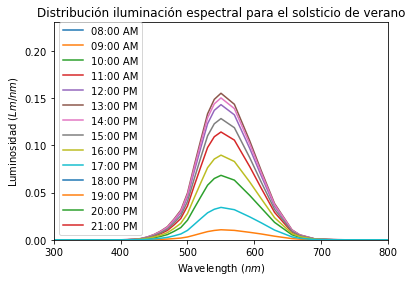

In [67]:
irrad_phot=[]
for i in range(len(spectra['poa_global'])):
    irrad_phot.append(spectra['poa_global'][i]*photopic_curve(spectra['wavelength'][i])*caracteristics_module['area']*683)

plt.figure()
plt.plot(spectra['wavelength'], irrad_phot)
plt.xlim(300, 800)
plt.ylim(0, 0.23)
plt.ylabel(r"Luminosidad ($Lm/nm$)")
plt.xlabel(r"Wavelength ($nm$)")
plt.title("Distribución iluminación espectral para el solsticio de verano")
time_labels = times.strftime("%H:%M %p")
labels = [
    "{}".format(*vals)
    for vals in zip(time_labels)
]
plt.legend(labels)
plt.show()

Esta distribución es un sistema aditivo. Se puede obtener el valor de la irradiancia total a una hora concreta haciendo el sumatorio del producto de cada longitud de onda por el valor de irradiancia espectral. 

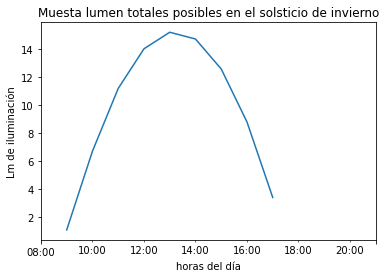

In [70]:
hour_irrad=[]
for i in range(len(irrad_phot[0])):
    a=0
    for j in range(len(irrad_phot)):
        if spectra['wavelength'][j]>=380 and spectra['wavelength'][j]<=770 :
                a=a+(float(spectra['wavelength'][j])-float(spectra['wavelength'][j-1]))*float(irrad_phot[j][i])
    hour_irrad.append(a)

hour_irrad=pd.Series(hour_irrad)
hour_irrad.index=times
hour_irrad.plot()
plt.xlabel('horas del día')
plt.ylabel('Lm de iluminación')
plt.title("Muesta lumen totales posibles en el solsticio de invierno")
plt.show()


## COMPARACIÓN CON SIN IRRADIANCIA ESPECTRAL CON LA CONSTANTE CONSIDERADA

In [75]:
data_location=gr.get_data_location(caracteristics,caracteristics_module,caracteristics['date']) 
lum_no_cell_=[]
for i in range(len(data_location['AOI'])):    
    lum_no_cell_.append(cell.from_rad_to_lum(data_location['POA_direct'][i],caracteristics_module['area']))
lum_no_cell=lum_no_cell_+cell.from_rad_to_lum(data_location['POA_diffuse'],caracteristics_module['area'])

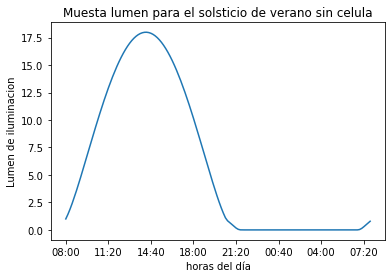

In [77]:
lum_no_cell.plot(label='iluminación modulo ')
plt.xlabel('horas del día')
plt.ylabel('Lumen de iluminacion')
plt.title("Muesta lumen para el solsticio de verano sin celula")
plt.show()